### Introduction

In this notebook, I tried to bactest 5 assets from SnP500 for 3 years (2018-21) using `zipline`.<br>
I've used `MACD` as a trend following indicator.<br>
Checked the performance of the strategy with the benchmark `SPY` using `quantstat` and explained the results.<br>

* Chosen assets from 5 different sectors for diversification.
* The strategy outperformed the benchmark.
* Explained the performance based on 5 metrics (Omega, Max drawdown, Sharp ratio, Cum returns, Vol)
* Explained all the steps I took.

## Table of Contents 📚
- [Introduction 📖](#Purpuse-of-this-Notebook)
   - [Import necessary libraries and modules 💻](#Import-necessary-libraries-and-modules)
   - [Asset Choosing 🔍](#Asset-Choosing)
   - [Preprocess the SnP500 data for ingesting into zipline 🔄](#Preprocess-the-SnP500-data-for-ingesting-into-zipline)
- [MACD as the Trend Following Indicator 📈](#MACD-as-the-Treand-Following-Indicator)
   - [Backtest with zipline 🧪](#Bactest-with-zipline-MACD)
   - [Functions for MACD Plotting 🎨](#Funtions-for-MACD-Plotting)
   - [Use Benchmark 'SPY' to Compare MACD Performance 📊](#Use-Benchmark-'SPY'-to-Compare-MACD-Performance)
   - [Quantstat Tearsheet for Macd 📄](#Quantstat-Tearsheet-for-Macd)
   - [Interpretation of MACD Performance 🧐](#Interpretation-of-MACD-Performance)
   - [Future Works 🚀](#Future-Works)

### Import necessary libraries and modules

In [1]:
import pandas as pd
import os
%load_ext zipline
from zipline.api import symbol, set_benchmark, order,record, order_target, get_open_orders,order_target_percent,set_benchmark
from zipline.utils.calendar_utils import get_calendar
from zipline import run_algorithm
import matplotlib.pyplot as plt
import numpy as np
from zipline.data import bundles
%matplotlib inline
import matplotlib.pyplot as plt
import quantstats as qs
from pyfolio.utils import extract_rets_pos_txn_from_zipline
from pyfolio.tears import create_full_tear_sheet

### Asset Choosing

I have chosen 5 assets from SnP500 from 5 different sectors to diversify the portfolio.<br>
The assets are as follows:
| Asset | Company Name            | Sector                 |
|-------|-------------------------|------------------------|
| AAPL  | Apple Inc.              | Information Technology |
| XOM   | Exxon Mobil Corporation | Energy                 |
| JPM   | JPMorgan Chase & Co.    | Financials             |
| LLY   | Eli Lilly and Company   | Health Care            |
| PEP   | PepsiCo, Inc.           | Consumer Staples       |

### Preprocess the SnP500 data for ingesting into zipline

In [24]:
# Commented the cell so that it doesn't run again
# input_path = '/home/yakub/Documents/Finance_Data/Data/S_P 500 returns/OHLCV'
# output_path = '/home/yakub/Documents/Python/preprocessed_zipline_data/snp500/daily'
# file_list = []

# for file in os.listdir(input_path):
#     file_path = os.path.join(input_path, file)
#     data = pd.read_csv(file_path)
#     data = data.rename(columns={'date': 'timestamp'})
#     data.columns = data.columns.str.lower()
#     data['timestamp'] = pd.to_datetime(data['timestamp'])
#     data = data.set_index('timestamp')
#     data.to_csv(os.path.join(output_path, file),index=True,index_label='timestamp')

## EMA

$$ EMA = multiplier*{(P_t - EMA_{t-1})} + EMA_{t-1} $$
$$ multiplier = \frac{2}{n+1} $$
$$ n = \text{number of days} $$
$$ P_t = \text{price at time t} $$
$$ ema = \text{exponential moving average} $$

In [2]:
def ema(day,price_hist):
    mulitplier = 2/(day+1)
    ema_list = []
    ema_prev = price_hist[0]
    ema_list.append(ema_prev)
    
    for price in price_hist[1:]:
        ema = (price - ema_prev) * mulitplier + ema_prev
        ema_list.append(ema)
        ema_prev =ema
    
    return ema_list

# MACD as the Treand Following Indicator

$$ MACD = EMA_{12} - EMA_{26} $$
$$ EMA_{12} = \text{12 day exponential moving average} $$
$$ EMA_{26} = \text{26 day exponential moving average} $$
$$ MACD_{signal} = EMA_{9} $$
$$ EMA_{9} = \text{9 day exponential moving average} $$
$$ MACD_{histogram} = MACD - MACD_{signal} $$

### Bactest with Zipline (MACD)

MACD is a trend following indicator. It is calculated by subtracting the 26-day exponential moving average (EMA) from the 12-day EMA. A nine-day EMA of the MACD, called the "signal line". 

**In this notebook I have used 12, 26 and 9 as the parameters for MACD and applied the following rules**<br>

* Generates a buy signal when the MACD crosses above its signal line and stays above the 100 long moving average which indicates an uptrend. Buy as many shares as possible.
* Sell - or short when the MACD crosses below the signal line and stays below the 100 long moving average which indicates a downtrend. Sell all the shares.

In [3]:
%%capture
calendar = get_calendar('XNYS')
capital_base = 10000

def initialize(context):
    context.i = 0
    context.assets = [symbol("AAPL"), symbol("XOM"), symbol("LLY"),symbol("JPM"),symbol("PEP")]
    
def handle_data(context, data):
    context.i += 1
    if context.i < 100: return
    for asset in context.assets:
        buy_signal = False
        sell_signal  =False
        price_hist = data.history(asset,'price', bar_count=26, frequency='1d')
        long_term_mavg = data.history(asset, 'close', bar_count=100, frequency='1d').mean()
        trend_up = price_hist[-1] > long_term_mavg
        
        ema_26 = ema(26,price_hist)
        ema_12 = ema(12,price_hist)
        MACD = [ema_12[j]-ema_26[j] for j in range(len(price_hist))]
        signal = ema(9,MACD)
        
        cash = context.portfolio.cash
        price = data.current(asset, "price") # current price of the stock
        
        open_orders = get_open_orders()
        if asset not in open_orders and data.can_trade(asset):
            if MACD[-1]>signal[-1] and MACD[-2] < signal[-2] and MACD[-1] > 0 and trend_up:    # Bullish crossover
                order_target(asset,cash // price) # buy as many shares as possible

            elif MACD[-1]<signal[-1] and MACD[-2] > signal[-2] and MACD[-1] < 0:    # Bearish crossover
                order_target(asset,0) # sell all shares
                
        record( closing_price = data.current(asset, "close"),
                MACD = MACD[-1],
                signal =signal[-1],
                long_term_mavg=long_term_mavg,
                )

start_date = pd.to_datetime('2018-01-02', format='%Y-%m-%d')
end_date = pd.to_datetime('2021-01-01', format='%Y-%m-%d')

result = run_algorithm(
    start = start_date,
    end = end_date,
    initialize=initialize,
    handle_data = handle_data,
    trading_calendar=calendar,
    bundle='sp5',
    capital_base=capital_base,
    data_frequency='daily'
)

## Funtions for MACD Plotting

In [4]:
def plot_macd(result, buy_signal=None, sell_signal=None):
    fig2, ax2 = plt.subplots(3, 1, figsize=(16, 12), gridspec_kw={'height_ratios': [2, 4, 2]})

    # Closing price and long MA
    result["closing_price"].plot(ax=ax2[0], color='green', title="Closing Price")
    result["long_term_mavg"].plot(ax=ax2[0], color='purple', label="100-period MA")
    ax2[0].legend()
    # MACD and signal line
    result["MACD"].plot(ax=ax2[1], color='blue', label="MACD")
    result["signal"].plot(ax=ax2[1], color='orange', label="Signal")
    ax2[1].legend()

    # Portfolio value
    result["portfolio_value"].plot(ax=ax2[2], color="blue", label="Portfolio Value")
    ax2[2].legend()
    plt.show()

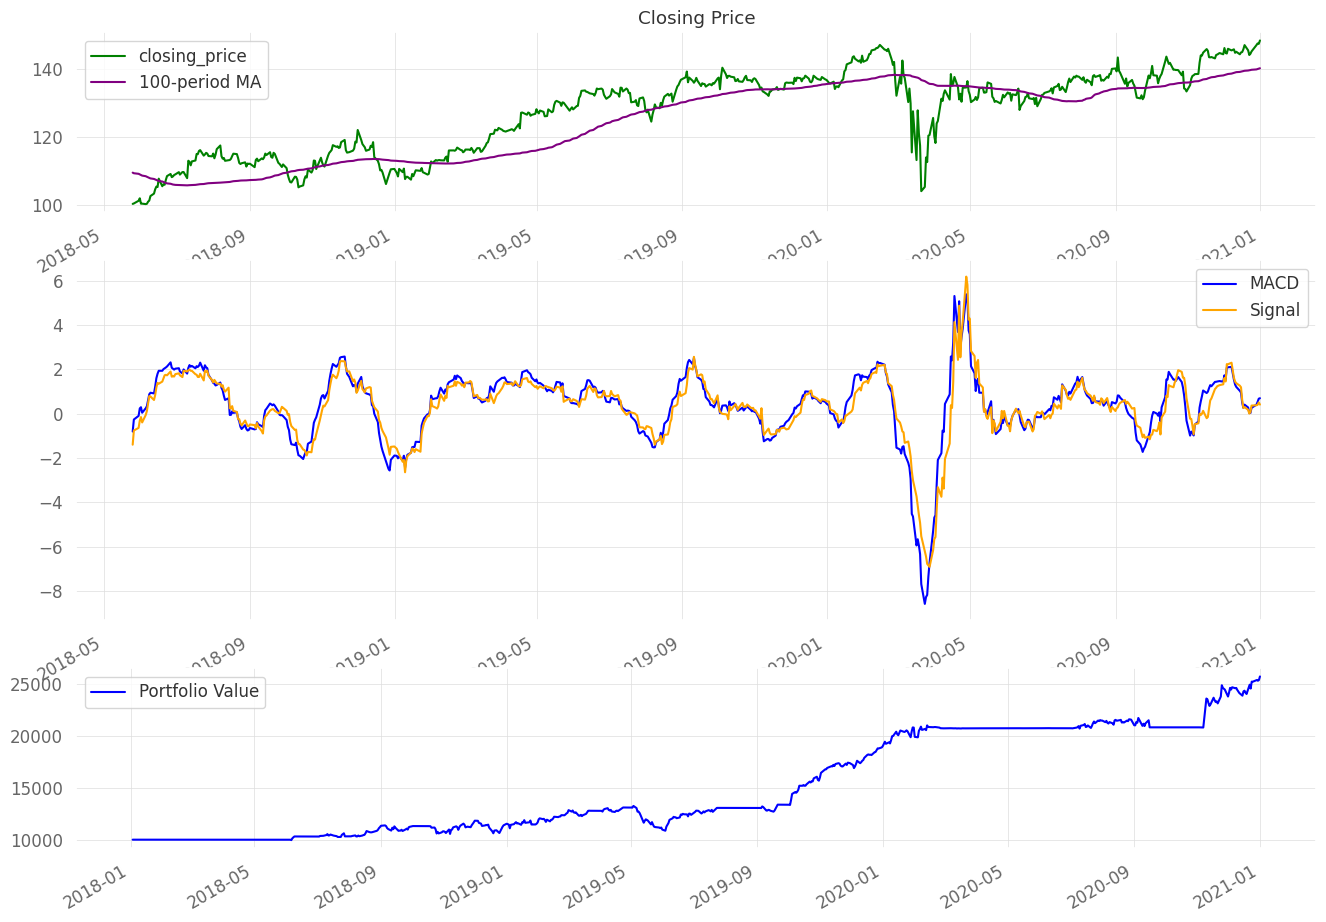

In [5]:
plot_macd(result)

## Use Benchmark 'SPY' to Compare MACD Performance

Extract a return series with time index from 'SPY' to make it compatible to use in `quantstats` library.

In [7]:
spy = pd.read_csv("custom_data/d1/spy.csv")
spy.timestamp = pd.to_datetime(spy.timestamp)
spy.set_index('timestamp',inplace=True)
spy_return_series = spy['close'].pct_change()
spy_return_series = spy_return_series['2018-01-02':'2021-01-01']

Convert the timezone to none to match it with the benchmark 'SPY'.

In [8]:
returns = result.returns
returns.index = returns.index.tz_localize(None)

### Quantstat Tearsheet for Macd 

/home/yakub/anaconda3/envs/ml/lib/python3.10/site-packages/quantstats/utils.py:269: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  .pct_change()


                    Benchmark    Strategy
------------------  -----------  ----------
Start Period        2018-06-04   2018-06-04
End Period          2020-12-31   2020-12-31
Risk-Free Rate      0.0%         0.0%
Time in Market      32.0%        84.0%

Cumulative Return   34.24%       141.79%
CAGR﹪              8.2%         26.67%

Sharpe              0.68         1.92
Prob. Sharpe Ratio  91.11%       99.96%
Sortino             1.47         3.33
Sortino/√2          1.04         2.35
Omega               1.59         1.59

Max Drawdown        -18.95%      -18.03%
Longest DD Days     359          148

Gain/Pain Ratio     0.41         0.59
Gain/Pain (1M)      1.24         4.15

Payoff Ratio        0.64         1.53
Profit Factor       1.41         1.59
Common Sense Ratio  1.53         2.12
CPC Index           0.51         1.28
Tail Ratio          1.09         1.33
Outlier Win Ratio   14.16        4.63
Outlier Loss Ratio  3.12         4.87

MTD                 2.15%        8.12%
3M          

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


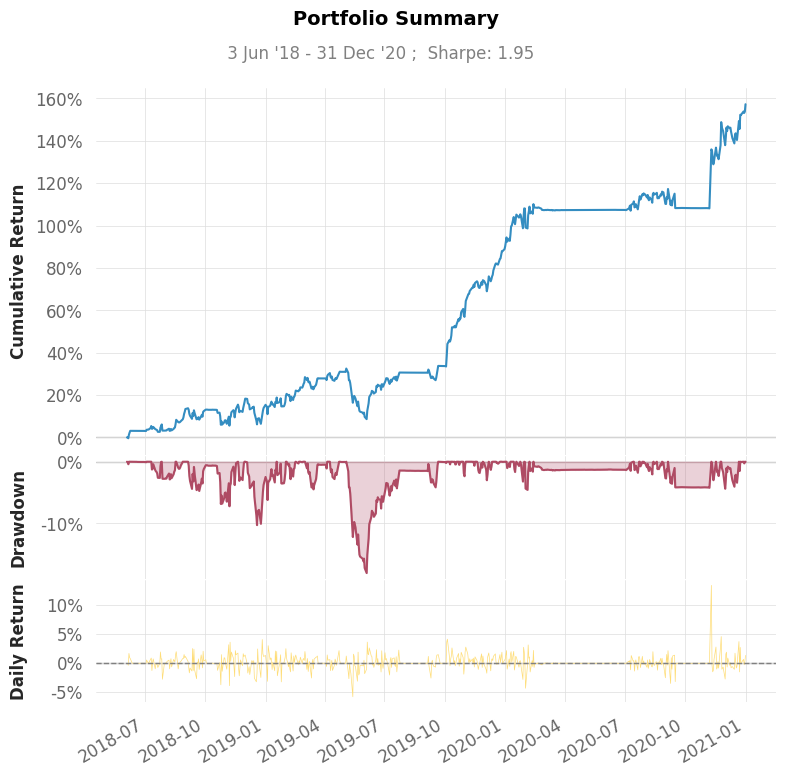

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


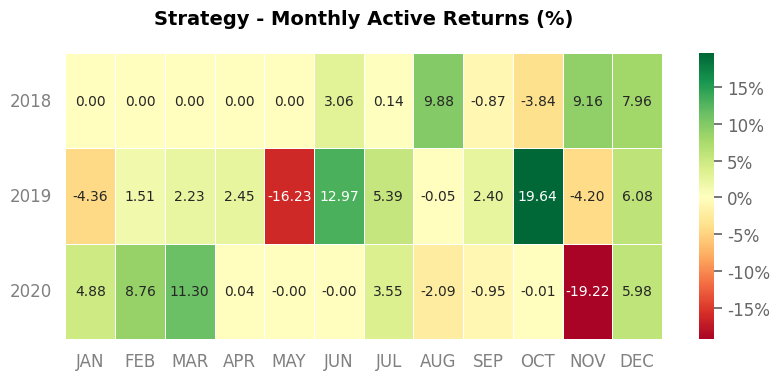

In [21]:
qs.reports.basic(returns,benchmark=spy_return_series)

### **Interpretation of MACD Performance**

The strategy with MACD indicator performs comparativly better than the benchmark.<br>

**Cumulative Return**          
* Benchmark: 34.24%         
* Strategy : 141.79%<br>

**Sharp Ratio**<br>

* Benchmark: 0.68
* Strategy: 1.92<br>

Our strategy achieved a higher cumulative return 141.79% and its Sharpe Ratio 1.92 is higher than the benchmark.<br>This suggests that the strategy generated returns at the cost of significantly lower risk or volatility compared to the benchmark 'SPY'.<br>

**Sortino Ratio**
* Benchmark: 1.47 
* Strategy: 3.33<br>

Our strategy achieved a higher Sortino Ratio 3.33 than the benchmark, meaning it generates better returns for the amount of downside risk it takes which is almost 2 times higher than the benchmark.

**Omega**
* Benchmark: 1.59
* Strategy: 1.59<br>

Both options offer similar downside protection with Omega values around 1.59, suggesting comparable protection against major losses and has a higher probability (1.59 times) of achieving a positive return than experiencing a loss.<br>

**Max Drawdown**
* Benchmark: -18.95% 
* Strategy: -18.03%

Our strategy experienced slightly lower drawdown compared to the benchmark. This indicates our strategy exposed almost similar or lower potential losses. <br>

**Decission Point**

**Suitible for investors seeking moderate returns with lower risk tolerance.**

# Future Works
- Parameter tuning for MACD: I have used 12, 26 and 9 as the parameters for MACD. But different parameters can be used to improve the performance.
- Diversification: I have chosen 5 assets from 5 different sectors to diversify the portfolio. But more assets can be added to improve the performance.
- Other indicators: Other indicators can be combined with MACD to improve the performance.
- Other benchmarks: Other benchmarks can be used to compare the performance of MACD.
- Machine Learning: Machine learning can be used to improve the performance of MACD.Like as gradient boosting, random forest, neural network etc.
